## Pseudo-label: The simple and efficient semi supervised learning method for deep neural networks

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset

import torchvision
from torchvision import transforms

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [2]:
# transforms

# stats for normalization
channel_stats = dict(mean=[0.4914, 0.4822, 0.4465],
                     std=[0.2470,  0.2435,  0.2616])

transform_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(**channel_stats),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(**channel_stats),
])

### load cifar 10 dataset

In [3]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

supervised, unsupervised = random_split(train, [10000, 40000])

val = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(train.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
def plot(data):
    
    x, y = data
    
    mean = torch.Tensor(channel_stats['std']).view(-1, 1, 1)
    
    std = torch.Tensor(channel_stats['mean']).view(-1, 1, 1)
    
    de_normalized = x * std + mean
            
    plt.imshow(de_normalized.permute(1, 2, 0))
    
    plt.title(train.classes[y])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


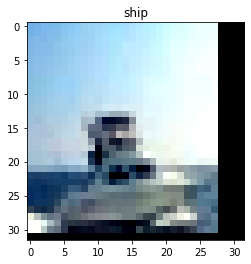

In [7]:
plot(train[100])

### DataLoaders

In [9]:
def collate_unsup(batch):
    # only return the images for the unsupervised dataloader
    return torch.stack([i[0] for i in batch]) # stack all the images

In [10]:
sup_batch_size = 128
mu = 4

sup_loader = DataLoader(supervised, batch_size=sup_batch_size, shuffle=True, num_workers=15)

unsup_loader = DataLoader(unsupervised, batch_size=sup_batch_size * mu, shuffle=True, collate_fn=collate_unsup, num_workers=15)

val_loader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=False, num_workers=15)

### Model

see Notebook **013 - Convolution Layer.ipynb**

$O = (I − K + 2 P)/S+1$

- O : output size
- I : input size
- K : kernel size
- P : padding
- S : stride

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fe = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1), # (32 - 3 + 2 * 0)/1 + 1 = 30
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1), # (30 - 3 + 2 * 0)/1 + 1 = 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), # (28 - 4 + 2 * 0)/2 + 1 = 13
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), # (13 - 3 + 2 * 0)/2 + 1 = 6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (6 - 2)/2 + 1 = 3
            nn.Dropout(0.1)
        )
        
        self.fc = nn.Linear(128 * 3 * 3, 10)
        
    def forward(self, x):
        
        # x of size [batch_size, 3, W, H]
        
        h = self.fe(x) # [batch_size, 128, 3, 3]
                
        h = h.view(-1, 128 * 3 * 3)
        
        return self.fc(h) # [batch_size, 10]

### Training loop

In [13]:
def train_pseudo_label(model: nn.Module,
                    opt: torch.optim,
                    sup_loader: torch.utils.data.DataLoader,
                    unsup_loader: torch.utils.data.DataLoader,
                    alpha: float=0.1):
    
    model.train()
    
    for param in model.parameters():
        device = param.device
        break
    
    losses = []
    
    pbar = tqdm(sup_loader)
    
    unsup_iter = iter(unsup_loader)
    
    for batch_sup in pbar:
        
        model.zero_grad()
                
        x, y = batch_sup
        
        x, y = x.to(device), y.to(device)
        
        # prediction for labelled data
        y_pred_sup = model.forward(x)
        
        # supervised cross-entropy loss
        loss_sup = F.cross_entropy(y_pred_sup, y)
                            
        try:
            batch_unsup = next(unsup_iter)
        except StopIteration:
            unsup_iter = iter(unsup_loader)
            batch_unsup = next(unsup_iter)
                
        x_unsup = batch_unsup.to(device)
        
        # prediction for unlabelled data
        y_pred_unsup = model.forward(x_unsup)
        
        # compute pseudo labels
        pseudo_label = torch.argmax(y_pred_unsup, dim=1)
        
        # cross-entropy using pseudo-labels
        loss_unsup = F.cross_entropy(y_pred_unsup, pseudo_label)
        
        # total loss
        loss = loss_sup + alpha * loss_unsup
        
        loss.backward()

        opt.step()
        
        loss_item = loss.item()
        
        losses.append(loss_item)
        
        pbar.set_description(f'train_loss = {np.array(losses).mean(): .3f}')
        
    return np.array(losses).mean()

@torch.no_grad()
def validate(model: nn.Module, dataloader: torch.utils.data.DataLoader):
    
    model.eval()
    
    for param in model.parameters():
        device = param.device
        break
     
    labels_all = []
    logits_all = []
    
    for x, y in dataloader:

        x, y = x.to(device), y.to(device)

        logits = model(x)
        
        labels_all += y.cpu().numpy().tolist()
        logits_all += logits.cpu().numpy().tolist()
        
    prediction = np.argmax(np.array(logits_all), axis=-1)
    
    acc = accuracy_score(labels_all, prediction)
                    
    return acc

### Rampup function for the unsupervised loss weight

In [14]:
def alpha_t(current, rampup_length):
    # linear rampup function
    assert current >= 0 and rampup_length >= 0
    if current >= rampup_length:
        return 1.0
    else:
        return current / rampup_length

Text(0, 0.5, 'alpha(t)')

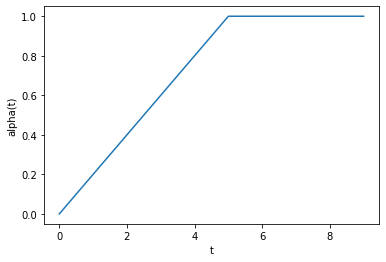

In [15]:
x = np.arange(0, 10)
y = [alpha_t(i, rampup_length=5) for i in x]

plt.plot(x, y)
plt.xlabel('t')
plt.ylabel('alpha(t)')

### Training

In [16]:
# initialize model

model = ConvNet().cuda()

opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [17]:
for t in range(5):
    alpha = alpha_t(t, rampup_length=5)
    train_pseudo_label(model, opt, sup_loader, unsup_loader, alpha=alpha)
    val_acc = validate(model, val_loader)
    print(val_acc)

  0%|          | 0/79 [00:00<?, ?it/s]

0.4084


  0%|          | 0/79 [00:00<?, ?it/s]

0.4723


  0%|          | 0/79 [00:00<?, ?it/s]

0.561


  0%|          | 0/79 [00:00<?, ?it/s]

0.5732


  0%|          | 0/79 [00:00<?, ?it/s]

0.6191


# Semi-supervised Learning by Entropy Minimization

In [15]:
def train_EntMin(model: nn.Module,
                    opt: torch.optim,
                    sup_loader: torch.utils.data.DataLoader,
                    unsup_loader: torch.utils.data.DataLoader,
                    alpha: float=0.1):
    
    model.train()
    
    for param in model.parameters():
        device = param.device
        break
    
    losses = []
    
    pbar = tqdm(sup_loader)
    
    unsup_iter = iter(unsup_loader)
    
    for batch_sup in pbar:
        
        model.zero_grad()
                
        x, y = batch_sup
        
        x, y = x.to(device), y.to(device)
        
        # prediction for labelled data
        y_pred_sup = model.forward(x)
        
        # supervised cross-entropy loss
        loss_sup = F.cross_entropy(y_pred_sup, y)
                            
        try:
            batch_unsup = next(unsup_iter)
        except StopIteration:
            unsup_iter = iter(unsup_loader)
            batch_unsup = next(unsup_iter)
                
        x_unsup = batch_unsup.to(device)
        
        # prediction for unlabelled data
        y_pred_unsup = model.forward(x_unsup)
        
        # entropy for each predition H = - p log p
        entropy = - (F.softmax(y_pred_unsup, dim=1) * F.log_softmax(y_pred_unsup, dim=1)).sum(1) # [batch_size,]        
        
        # cross-entropy using pseudo-labels
        loss_unsup = entropy.mean()
        
        # total loss
        loss = loss_sup + alpha * loss_unsup
        
        loss.backward()

        opt.step()
        
        loss_item = loss.item()
        
        losses.append(loss_item)
        
        pbar.set_description(f'train_loss = {np.array(losses).mean(): .3f}')
        
    return np.array(losses).mean()

In [18]:
# Entropy minimization example

y = torch.Tensor([0.1, 0.2, 0.3]) / 5 # unormalized probability

y = nn.Parameter(y) # enable gradient

print('Original:', F.softmax(y, dim=0).detach().numpy())
print('\n')

for i in range(20):
    
    entropy = - F.softmax(y, dim=0) * F.log_softmax(y, dim=0)
    
    entropy = entropy.sum() # entropy
    
    if i == 0:
        print('initial entropy:', entropy.item())
        print('\n')
    
    entropy.backward() # backprop
        
    y.data -=  y.grad # gradient descent 
    
    y.grad.data.zero_() 
    
    print('Updated', F.softmax(y, dim=0).detach().numpy())
    
print('\n')    
print('final entropy:', entropy.item())

Original: [0.32668933 0.3332889  0.3400218 ]


initial entropy: 1.09847891330719


Updated [0.32449988 0.33322474 0.34227544]
Updated [0.3216     0.33310086 0.3452992 ]
Updated [0.31776777 0.3328676  0.34936464]
Updated [0.31271854 0.3324359  0.35484546]
Updated [0.30609217 0.33164698 0.36226085]
Updated [0.29744136 0.33021888 0.37233973]
Updated [0.2862253  0.32765654 0.3861182 ]
Updated [0.27181265 0.32310274 0.40508464]
Updated [0.25350326 0.31511274 0.43138397]
Updated [0.23058014 0.30137447 0.46804532]
Updated [0.20243311 0.27857518 0.5189917 ]
Updated [0.16891213 0.24313658 0.5879513 ]
Updated [0.13131602 0.19430093 0.6743831 ]
Updated [0.09397895 0.13931061 0.76671046]
Updated [0.0634259  0.09210271 0.8444714 ]
Updated [0.04286385 0.06044535 0.8966908 ]
Updated [0.03031503 0.04158869 0.92809635]
Updated [0.02262505 0.03033931 0.9470357 ]
Updated [0.01768223 0.02327775 0.95904005]
Updated [0.01432997 0.01858259 0.9670874 ]


final entropy: 0.19899101555347443


In [88]:
# Prediction is more and more confident, entropy is lower